## EECS491 A4 E1
### Tristan Maidment (tdm47)

#### Goal
The goal of this exercise was to implement the Expectation Maximization (EM) algorithm for the just the mean of two clusters.  EM is a form of semi-unsupervised learning.

#### Derivation (EM Algorithm)
This derivation of the EM algorithm was written with respect to notation provided in *Bayesian Reasoning and Machine Learning* by David Barber, page 447.

##### M-Step
To maximize the mean with respect to the current distribution parameters, the M-step is equivalent to minimizing:
\begin{equation*}
\sum_{n=1}^N \sum_{i=1}^H p^{old}(i|x^n)[-\frac{1}{2}(x^n - m_i)^T S_i^{-1} (x^n - m_i)]
\end{equation*}
The next step is to differentiate the equation with respect to **m**, and set the equation equal to zero.
\begin{equation*}
-2 \sum_{n=1}^N p^{old}(i|x^n)[-\frac{1}{2} S_i^{-1} (x^n - m_i)] = 0
\end{equation*}
Since the equation is solved, we can find the value of **m** with respect to the old value of **p**.
\begin{equation*}
\mathbf{m_i} = \frac{\sum_{n=1}^N p^{old} (i|x^n)x^n}{\sum_{n=1}^N p^{old} (i|x^n)}
\end{equation*}
The membership distribution can be defined as follows:
\begin{equation*}
p^{old}(n|i) = \frac{p^{old}(i|x^n)}{\sum_{n=1}^N p^{old}(i|x^n)}
\end{equation*}
This can be substituted into the previous equation to find the new value of **m**.
\begin{equation*}
\mathbf{m_i}^{new} = \sum_{n=1} p^{old}(n|i)(x^n - m_i)^2
\end{equation*}
This is the new updated value for each cluster *i*'s mean.

##### E-Step
The expectation step is calculated via the general formula (Bayes):
\begin{equation*}
p(i|x^n) = p(x^n|i)p(i)
\end{equation*}
For the 
\begin{equation*}
p(i|x^n) = \frac{p(i)exp[-\frac{1}{2}(x^n - m_i)^T S_i^{-1}(x^n - m_i)]det(S_i)^{-\frac{1}{2}}}
{\sum_{i'} p(i')exp[-\frac{1}{2}(x^n - m_{i'})^T S_{i'}^{-1}(x^n - m_{i'})]det(S_{i'})^{-\frac{1}{2}}}
\end{equation*}
This equation is repeatedly run with the M-step equation derived for mean, until convergence. 

#### Implementation

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import mnist
import copy
from scipy.stats import chi2, multivariate_normal

ngmm = 2

For this exercise, I define `truth` values for each cluster being approximated.  This will allow me to check the accuracy of the EM value algorithm after a couple of iterations.

In [2]:
mu = np.asarray([[1,60], 
                 [3, 80]]
               ).astype('float')

sigma = np.asarray([[[1, 0], 
                     [0, 42]], 
                    [[0.5, 0], 
                     [0, 3]]]
                  ).astype('float')

truth_mu = np.asarray([[2, 70], 
                 [4, 80]]
               ).astype('float')

truth_sigma = np.asarray([[[1, 0], 
                     [0, 3]], 
                    [[0.5, 0.2], 
                     [0.2, 0.6]]]
                  ).astype('float')

I then sample 100 points from the both truth distributions, for the EM value to fit to.  These points should be sufficient for the EM algorithm to be able to determine the cluster parameters within a few iterations.

In [3]:
mu_dist_1 = np.random.multivariate_normal(truth_mu[0], truth_sigma[0], 50)
mu_dist_2 = np.random.multivariate_normal(truth_mu[1], truth_sigma[1], 50)

I have imported some of the functions defined in the example code from plotting the distributions.

In [4]:
## functions used from the example code provided in class for plotting the distributions.
def plotGaussianModel2D(mu, sigma, pltopt='k'):
    if sigma.any():
        # calculate ellipse constants
        c = chi2.ppf(0.9, 2) # use confidence interval 0.9
        # get eigen vector and eigen values
        eigenValue, eigenVector = np.linalg.eig(sigma)
        # calculate points on ellipse
        t = np.linspace(0, 2*np.pi, 100) # draw 100 points
        u = [np.cos(t), np.sin(t)]
        w = c * eigenVector.dot(np.diag(np.sqrt(eigenValue)).dot(u))
        z = w.T + mu
    else:
        z = mu
    # plot ellipse by connecting sample points on curve
    plt.plot(z[:,0], z[:,1], pltopt)
    
def colorPicker(index):
    colors = 'rgbcmyk'
    return colors[np.remainder(index, len(colors))]

def gmmplot(data, gmm):
    # plot data points
    plt.scatter(data[:, 0], data[:, 1], s=4)
    # plot Gaussian model
    for index, model in enumerate(gmm):
        plotGaussianModel2D(model['mean'], model['covariance'], colorPicker(index))

In [5]:
gmm = [{'mean': mu[m], 'covariance': sigma[m], 'prior': 1.0/ngmm} for m in range(ngmm)]

To visualize the convergence, I have shown the original clusters, and their corresponding data.  We can see that they are close guesses of the data, but do not capture the mean of the clusters well enough.

Cluster 0 {'mean': array([ 1., 60.]), 'covariance': array([[ 1.,  0.],
       [ 0., 42.]]), 'prior': 0.5} Cluster 1 {'mean': array([ 3., 80.]), 'covariance': array([[0.5, 0. ],
       [0. , 3. ]]), 'prior': 0.5}


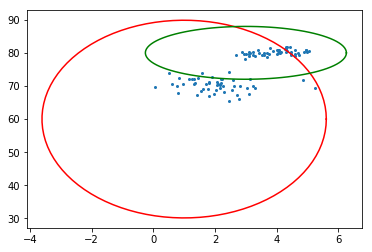

In [6]:
data = np.concatenate((mu_dist_1, mu_dist_2), axis=0)
print("Cluster 0", gmm[0], "Cluster 1", gmm[1])
gmmplot(data, gmm)

To help the clusters converge with the true mean of the data, we define both the `expectation` and `maximization` steps.

The `expectation` step assigns the `posterior` value of each point, or the probability that a point is contained by each cluster, respectively.  For this example, it returns two lists equal to the size of the data, one for each cluster.

The `maximization` step utilizes the `posterior` of each data point to create a weighted summation of the mean location of the cluster.  By weighting the points by the probablity that they are contained by the distribution, it prevents both clusters from converging to the whole dataset.

In [7]:
def expectation(data, gmmcp):
    num = np.zeros((len(gmmcp), data.shape[0]))
    den = np.zeros((len(gmmcp), data.shape[0]))
    for k in range(len(gmmcp)):
        #print(gmmcp[k]["mean"], gmmcp[k]["covariance"])
        num[k] = gmmcp[k]["prior"] * multivariate_normal.pdf(data, gmmcp[k]["mean"], gmmcp[k]["covariance"])
        for l in range(len(gmmcp)):
            den[k] += gmmcp[l]["prior"] * multivariate_normal.pdf(data, gmmcp[l]["mean"], gmmcp[l]["covariance"])
    return np.divide(num, den)

def maximization(posterior, data, gmmcp):
    # calculate Nk
    N = np.zeros(len(gmmcp))
    for k in range(N.shape[0]):
        N[k] = np.sum(posterior[k])
    
    mu = np.zeros((len(gmmcp), len(gmmcp[0]["mean"])))
    for k in range(mu.shape[0]):
        for n in range(data.shape[0]):
            mu[k] += posterior[k, n] * data[n] 
        gmmcp[k]["mean"] = 1/N[k] * mu[k]
        
    prior = np.zeros(len(gmmcp))
    for k in range(prior.shape[0]):
        prior[k] = np.divide(N[k],N.sum())
        gmmcp[k]["prior"] = prior[k]
        
    return gmmcp
    

Now that the `expectation` and `maximization` functions have been defined, the only step is iteratively apply them until they converge.  Due to the simplicity of this model, it is converges within the first few iterations.

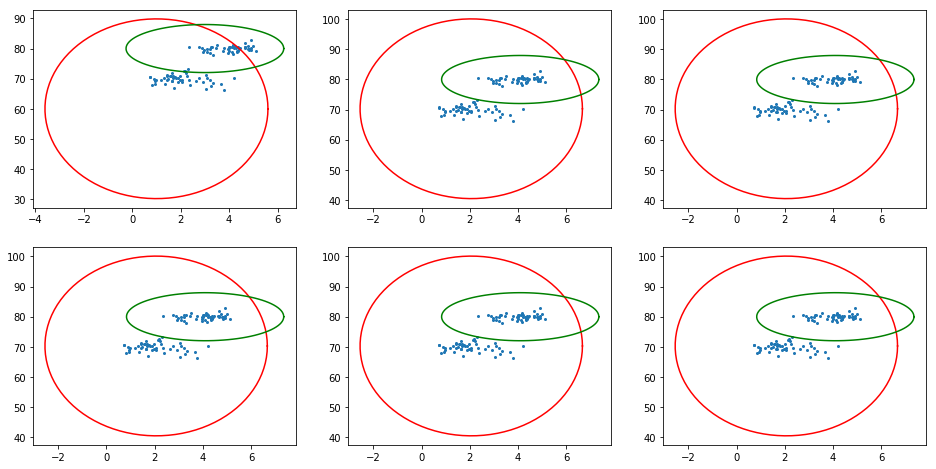

In [10]:
# make a true copy of our model
gmmcp = copy.deepcopy(gmm)

pi = np.array([0.5, 0.5])
# create figure
plt.figure(figsize=(16, 8))
# improve model with EM-Algorithm
for i in range(5):
    # plot current status
    plt.subplot(231 + i)
    gmmplot(data, gmmcp)
    #plt.show()
    # excute EM-Algorithm
    for j in range(5):
        #print((gmmcp[0]["covariance"]).shape)
        posterior = expectation(data, gmmcp)
        #print("Posterior:", posterior)
        gmmcp = maximization(posterior, data, gmmcp)
# plot final status
plt.subplot(236)
gmmplot(data,gmmcp)

### Conclusion
As we can see, the center of each cluster now corresponds with the center of each distribution.  We can conclude that the mean function of the EM algorithm works correctly.
Overall, finding the mean of the clusters for the EM algorithm is very straight forward.  